In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from config import *
from constants import *
from dataset import CommaDataset

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
dataset = CommaDataset(BASE_DIR, cache=False, read_from_cache=False)

[*] Initializing val dataset


11/11 - 18177: 100%|██████████| 11/11 [01:27<00:00,  7.99s/it]

[*] Dataset indices: [52721, 111713, 131443, 187608, 213472, 298767, 377229, 407766, 459456, 504247, 522423]
[*] Dataset length: 522424
[+] Dataset initialized


In [ ]:
from vqvae_simple import VQVAE

MODEL_PATH = "checkpoints/vqvae.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"  
vqvae = VQVAE(in_size=3, out_size=3).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
vqvae.load_state_dict(checkpoint["model"])

RuntimeError: Error(s) in loading state_dict for VQVAE:
	Missing key(s) in state_dict: "encoder.encoder.0.weight", "encoder.encoder.0.bias", "encoder.encoder.1.weight", "encoder.encoder.1.bias", "encoder.encoder.1.running_mean", "encoder.encoder.1.running_var", "encoder.encoder.3.weight", "encoder.encoder.3.bias", "encoder.encoder.4.weight", "encoder.encoder.4.bias", "encoder.encoder.4.running_mean", "encoder.encoder.4.running_var", "latent_space.pre_quant_conv.weight", "latent_space.pre_quant_conv.bias", "latent_space.embedding.weight", "latent_space.post_quant_conv.weight", "latent_space.post_quant_conv.bias", "decoder.decoder.0.weight", "decoder.decoder.0.bias", "decoder.decoder.1.weight", "decoder.decoder.1.bias", "decoder.decoder.1.running_mean", "decoder.decoder.1.running_var", "decoder.decoder.3.weight", "decoder.decoder.3.bias". 
	Unexpected key(s) in state_dict: "pre_quantization_conv.weight", "pre_quantization_conv.bias", "vector_quantization.embedding.weight", "encoder.conv_stack.0.weight", "encoder.conv_stack.0.bias", "encoder.conv_stack.2.weight", "encoder.conv_stack.2.bias", "encoder.conv_stack.4.weight", "encoder.conv_stack.4.bias", "encoder.conv_stack.5.stack.0.res_block.1.weight", "encoder.conv_stack.5.stack.0.res_block.3.weight", "encoder.conv_stack.5.stack.1.res_block.1.weight", "encoder.conv_stack.5.stack.1.res_block.3.weight", "decoder.inverse_conv_stack.0.weight", "decoder.inverse_conv_stack.0.bias", "decoder.inverse_conv_stack.1.stack.0.res_block.1.weight", "decoder.inverse_conv_stack.1.stack.0.res_block.3.weight", "decoder.inverse_conv_stack.1.stack.1.res_block.1.weight", "decoder.inverse_conv_stack.1.stack.1.res_block.3.weight", "decoder.inverse_conv_stack.2.weight", "decoder.inverse_conv_stack.2.bias", "decoder.inverse_conv_stack.4.weight", "decoder.inverse_conv_stack.4.bias". 

In [14]:
vqvae

VQVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (latent_space): VQLatentSpace(
    (pre_quant_conv): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
    (embedding): Embedding(3, 2)
    (post_quant_conv): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): Tanh()
    )
  

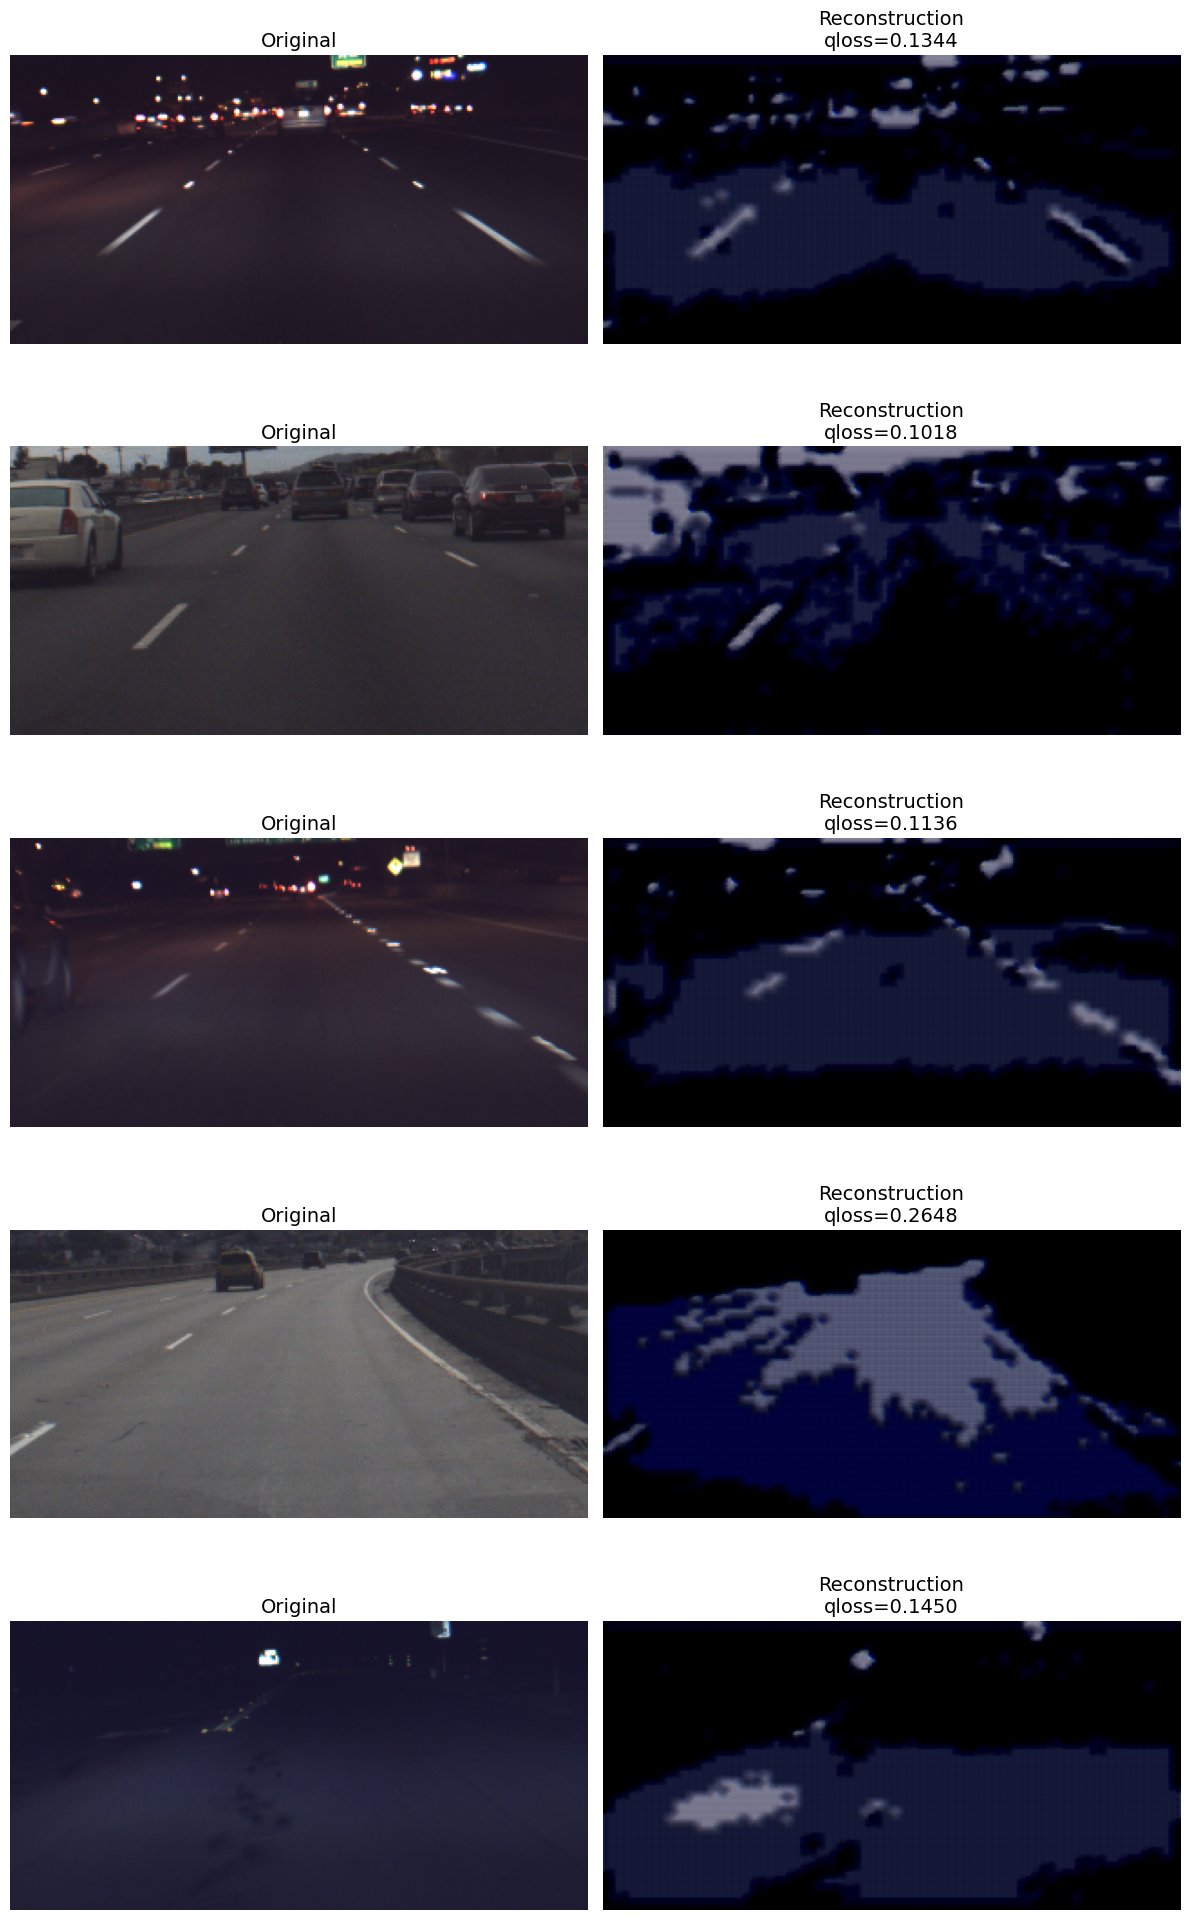

In [44]:
import random

num_samples = 5
indices = random.sample(range(len(dataset)), num_samples)

# Increase figure size for bigger images
plt.figure(figsize=(12, num_samples * 4))

for i, idx in enumerate(indices):
    data = dataset[idx]
    
    # Original image
    disp = data["disp_image"]  # uint8 CHW
    orig = np.transpose(disp, (1, 2, 0))  # CHW → HWC
    
    # Model reconstruction
    image = data["image"].unsqueeze(0).to(device)  # normalized tensor
    recon, qloss = vqvae(image)
    recon = recon.squeeze(0).cpu().detach().numpy()
    recon = np.transpose(recon, (1, 2, 0))  # CHW → HWC
    recon = (recon + 1) / 2  # [-1,1] → [0,1]
    recon = np.clip(recon, 0, 1)
    
    # Plot original
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(orig)
    plt.title("Original", fontsize=14)
    plt.axis("off")
    
    # Plot reconstruction
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(recon)
    plt.title(f"Reconstruction\nqloss={qloss.item():.4f}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:
import torch

from config import *
from constants import *
from vqvae.models.vqvae import VQVAE

MODEL_PATH = "checkpoints/paper_loss/vqvae.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"  
cfg = VQVAEConfig()
model = VQVAE(
  cfg.n_hiddens,
  cfg.n_residual_hiddens,
  cfg.n_residual_layers,
  cfg.n_embeddings,
  cfg.embedding_dim,
  cfg.beta
).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [7]:
print(model)

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_quantization_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (vector_quantization): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (inverse_conv_stack): Sequential(
      (0): Con

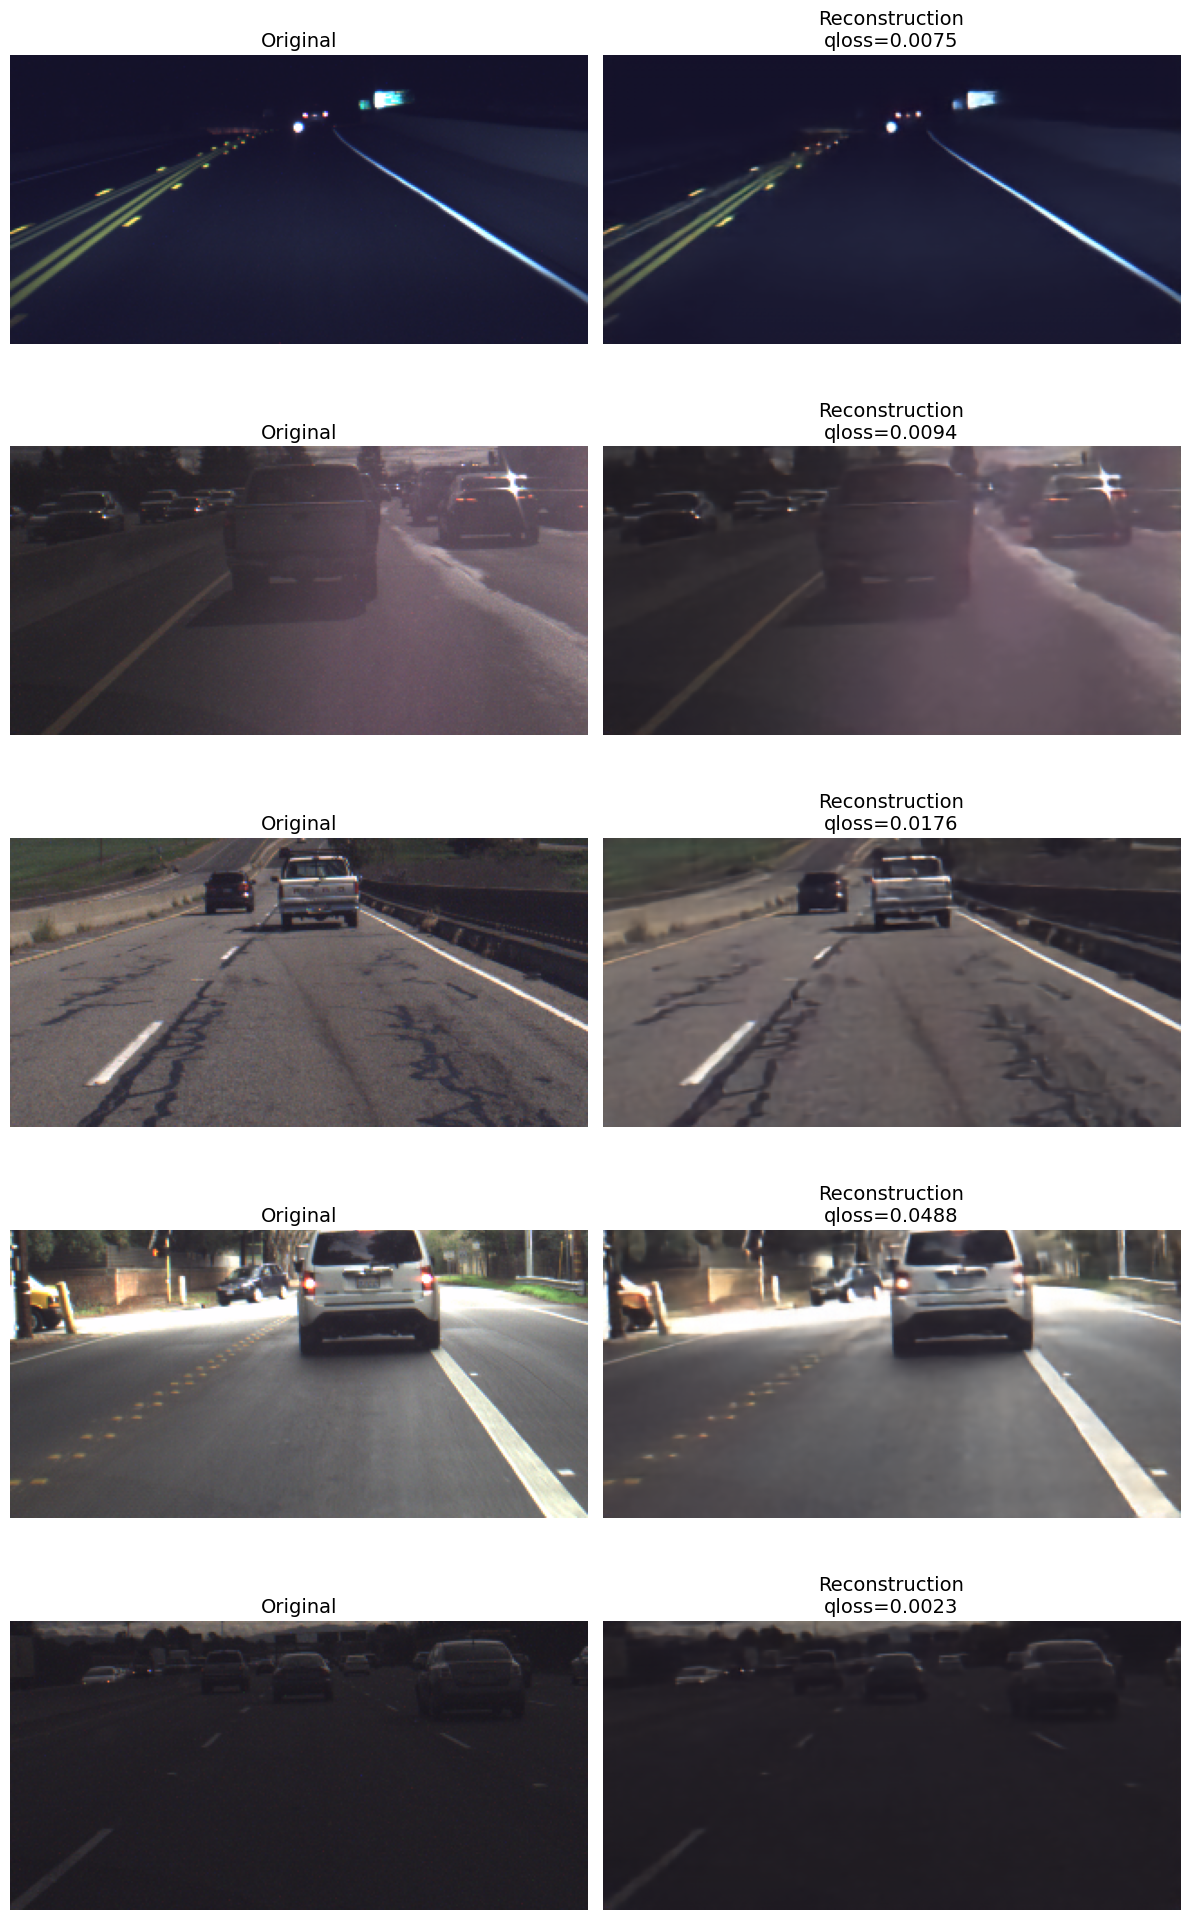

In [20]:
import random

num_samples = 5
indices = random.sample(range(len(dataset)), num_samples)

# Increase figure size for bigger images
plt.figure(figsize=(12, num_samples * 4))

for i, idx in enumerate(indices):
    data = dataset[idx]
    
    # Original image
    disp = data["disp_image"]  # uint8 CHW
    orig = np.transpose(disp, (1, 2, 0))  # CHW → HWC
    
    # Model reconstruction
    image = data["image"].unsqueeze(0).to(device)  # normalized tensor
    qloss, recon, perplexity = model(image)
    recon = recon.squeeze(0).cpu().detach().numpy()
    recon = np.transpose(recon, (1, 2, 0))  # CHW → HWC
    recon = recon * IMAGENET_STD + IMAGENET_MEAN      # back to [0,1]
    recon = np.clip(recon, 0, 1)
    
    # Plot original
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(orig)
    plt.title("Original", fontsize=14)
    plt.axis("off")
    
    # Plot reconstruction
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(recon)
    plt.title(f"Reconstruction\nqloss={qloss.item():.4f}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
import torch

from config import *
from constants import *
from vqvae.models.vqvae import VQVAE

MODEL_PATH = "checkpoints/compression_1280_bits/vqvae.pt"

@dataclass
class VQVAEConfig:
  n_hiddens: int = 128
  n_residual_hiddens: int = 32
  n_residual_layers: int = 2
  n_embeddings: int = 256
  embedding_dim: int = 32
  beta: float = 0.25
  stride: int = 4 # total downsampling factor of the encoder

device = "cuda" if torch.cuda.is_available() else "cpu"  
cfg = VQVAEConfig()
model = VQVAE(
  cfg.n_hiddens,
  cfg.n_residual_hiddens,
  cfg.n_residual_layers,
  cfg.n_embeddings,
  cfg.embedding_dim,
  cfg.beta
).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

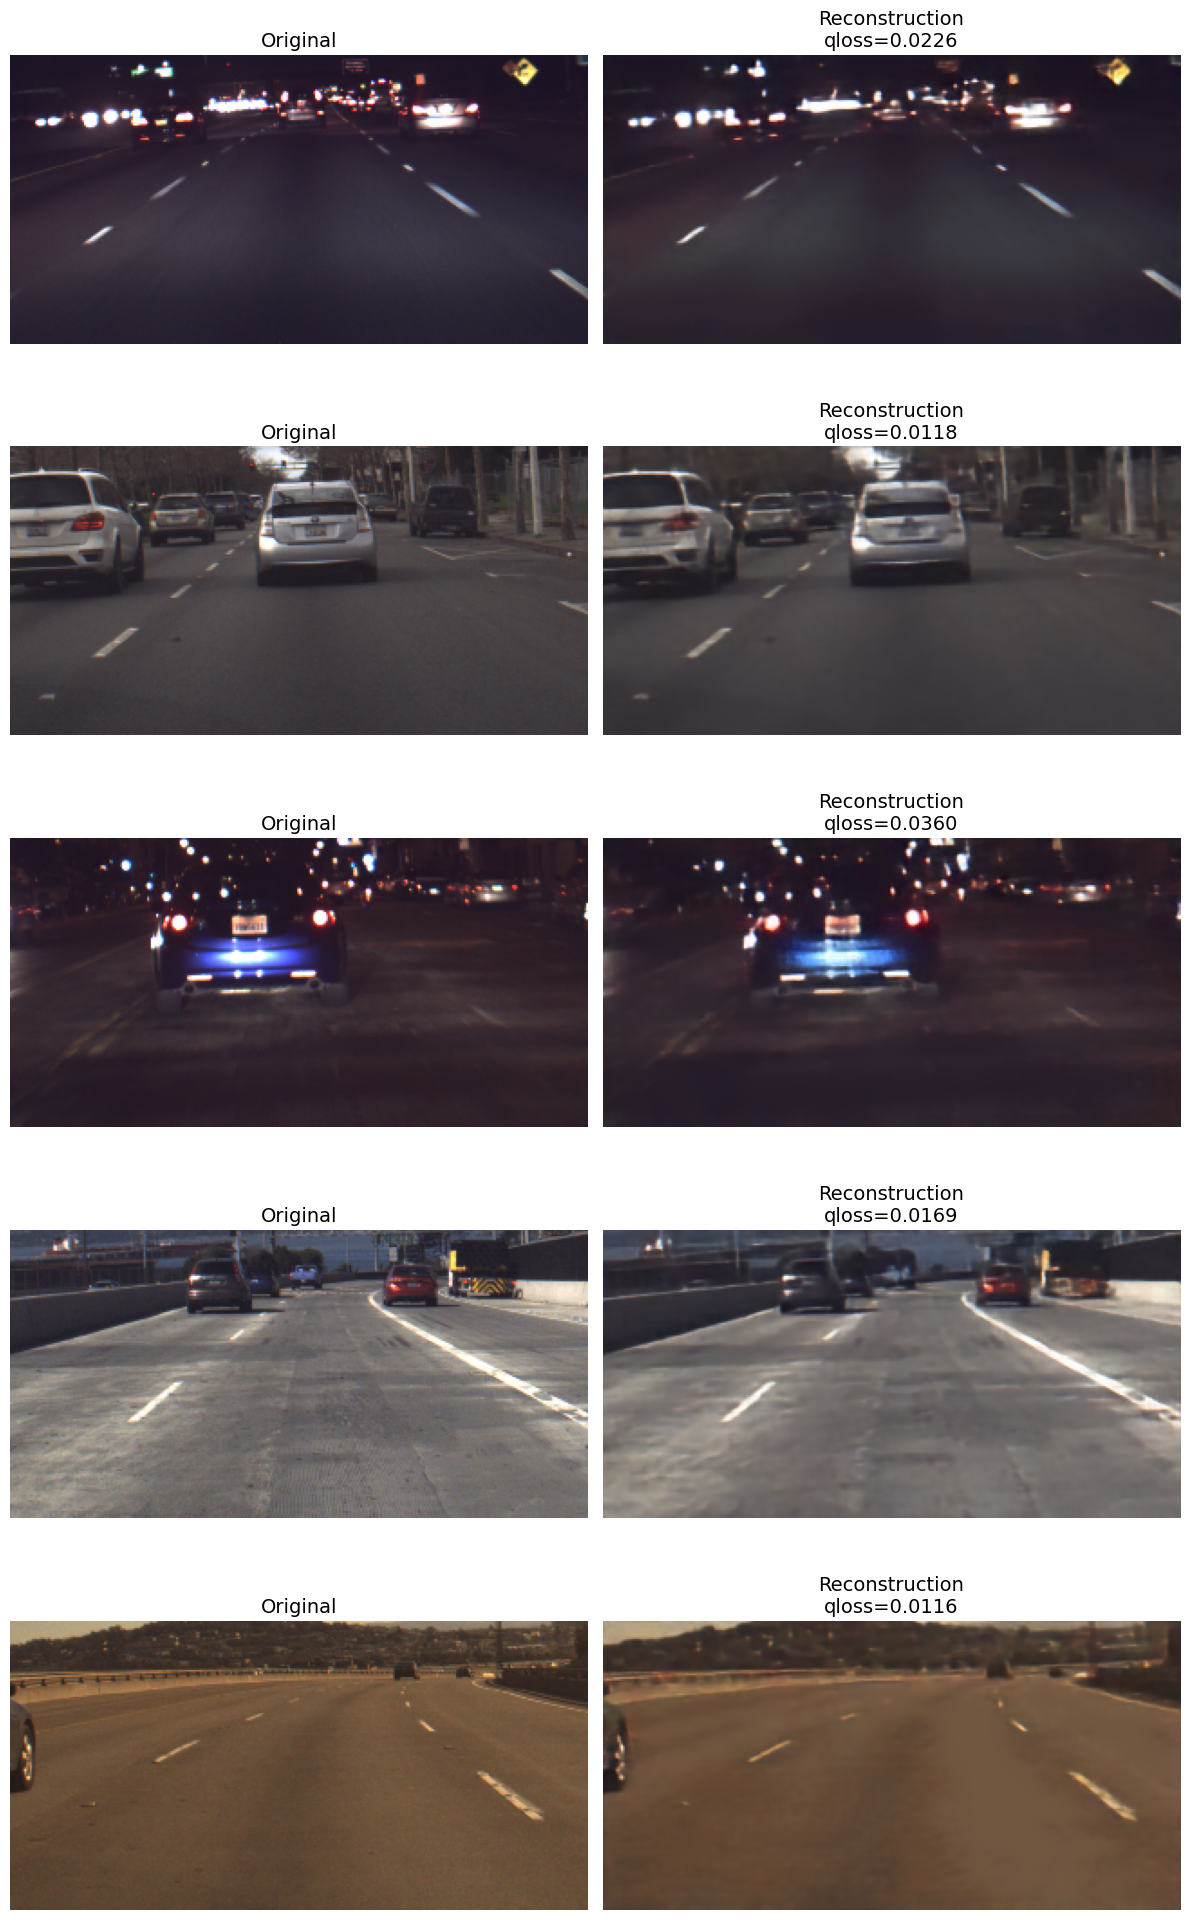

In [28]:
import random

num_samples = 5
indices = random.sample(range(len(dataset)), num_samples)

# Increase figure size for bigger images
plt.figure(figsize=(12, num_samples * 4))

for i, idx in enumerate(indices):
    data = dataset[idx]
    
    # Original image
    disp = data["disp_image"]  # uint8 CHW
    orig = np.transpose(disp, (1, 2, 0))  # CHW → HWC
    
    # Model reconstruction
    image = data["image"].unsqueeze(0).to(device)  # normalized tensor
    qloss, recon, perplexity = model(image)
    recon = recon.squeeze(0).cpu().detach().numpy()
    recon = np.transpose(recon, (1, 2, 0))  # CHW → HWC
    recon = recon * IMAGENET_STD + IMAGENET_MEAN      # back to [0,1]
    recon = np.clip(recon, 0, 1)
    
    # Plot original
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(orig)
    plt.title("Original", fontsize=14)
    plt.axis("off")
    
    # Plot reconstruction
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(recon)
    plt.title(f"Reconstruction\nqloss={qloss.item():.4f}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()